We are going to gather, look and analyze data about UFC events and fights from UFC 2 in 1994 till today. 
The data will be scraped from <a href='http://ufcstats.com/statistics/events/completed'>ufcstats.com</a> and strored in two .csv files:

<li>events.csv - includes information on every UFC event since 1994</li>
<li>fights.csv - includes information on every UFC fight since 1994</li>
    

Both datasets will be used for exploritory analysis trying to answer below questions:
<li>Did global pandemic influenced the number of events UFC had in 2020?</li>
<li>What are the most common destinations for UFC events and has they changed in 2020?</li>
<li>What is the most exciting weightclass to watch?</li>

### Step 1. Gather and understand the data.

In [1]:
# imports for webscraping
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

# import for dataframes
import pandas as pd

#  EVERY EVENT'S GENERAL INFO FROM UFCSTATS.COM

# webpage to scrap from
my_url = "http://ufcstats.com/statistics/events/completed?page=all"

# parsing the page
uClient = uReq(my_url)
page_html = uClient.read()
fight_events = soup(page_html, "html.parser")

# the page consists of tables with every event general info (name, date, place and link to event's stats)
# creating a list of those tables
containers = fight_events.findAll("td",{"class":"b-statistics__table-col"})

# first two items in the list don't contain any relevant information
del containers[:2]

# a dictionary for events' info
events = {
    "event name":[],
    "event date":[],
    "event place":[],
    "event link":[]
}


# so every even value of the list has event's name, date and link while every odd value has event's place
# iterating through the list of tables from the webpage to fill out dictionary
for i in range(len(containers)):
    
    if i%2==0:
        events["event name"].append(containers[i].a.text.strip())
        events["event date"].append(containers[i].span.text.strip())
        events["event link"].append(containers[i].a['href'])
    else:
        events["event place"].append(containers[i].text.strip())
        
# a dataframe for later use        
events = pd.DataFrame(data=events)

# saving dataframe into .csv file
events.to_csv("events.csv", index=False)


#  EVERY EVENT'S FIGHT INFORMATION

# a dictionary that will hold all the information scrapped
fights = {
    "fight date":[],
    "fight weightclass":[],
    "win method":[],
    "rounds":[],
    "time":[],
    "Winner":[],
    "Loser":[],
}
    

#using links from events_data dataframe to get stats for each fight    
for link in events["event link"]:
    
    uClient = uReq(link)
    page_html = uClient.read()
    uClient.close()
    
    #parsed webpage of the event
    event_page = soup(page_html, "html.parser")
    
    
    #event's every fight (general info)
    containers = event_page.findAll("tr",{"class":"b-fight-details__table-row b-fight-details__table-row__hover js-fight-details-click"})
    
    #looping through every fight to scrap general info to fill out dictionary
    for container in containers:
        
        stats = container.findAll("p",{"class":"b-fight-details__table-text"})
        
        #stats contain every p class element of the table, p class is basically a cell of the table on the webpage
        #some cells are split in two some not
        #the first page has a winn/draw info of the fight. If there is a draw that cell is split in two (draw / draw)
        #which creates additional element and makes len(stats) one element bigger. 
        #that's why if there's a 'win' in the first cell I'll delete the first element from the list (don't need that info)
        #but if there's a 'draw' I'll delete first two elements to make the length of the list same for each iteration
        
        if stats[0].i.text == 'win':
            del stats[0]
        else:
            del stats[0:2]
        
        #filling out the dictionary with scrapped information
        fights["fight date"].append(event_page.find("li",{"class":"b-list__box-list-item"}).text.split(":")[1].strip())
        fights["Winner"].append(stats[0].a.text.strip())
        fights["Loser"].append(stats[1].a.text.strip())
        fights["fight weightclass"].append(stats[10].text.strip())
        fights["win method"].append(stats[11].text.strip())
        fights["rounds"].append(int(stats[13].text.strip()))
        fights["time"].append(stats[14].text.strip())
        
        
#creating a dataframe out of dictionary        
fights = pd.DataFrame(data=fights)

#saving data into .csv file
fights.to_csv("fights.csv", index=False)

Now, after we gathered the data let's have a look at our dataframes.

In [4]:
events.head()

,event name,event date,event place,event link
0,UFC 256: Figueiredo vs. Moreno,"December 12, 2020","Las Vegas, Nevada, USA",http://ufcstats.com/event-details/d0d43cb9b14f...
1,UFC Fight Night: Hermansson vs. Vettori,"December 05, 2020","Las Vegas, Nevada, USA",http://ufcstats.com/event-details/398b440e73d5...
2,UFC Fight Night: Smith vs. Clark,"November 28, 2020","Las Vegas, Nevada, USA",http://ufcstats.com/event-details/992c82450d96...
3,UFC 255: Figueiredo vs. Perez,"November 21, 2020","Las Vegas, Nevada, USA",http://ufcstats.com/event-details/bbb15f301e4a...
4,UFC Fight Night: Felder vs. Dos Anjos,"November 14, 2020","Las Vegas, Nevada, USA",http://ufcstats.com/event-details/3bc27ec15fac...


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   event name   544 non-null    object
 1   event date   544 non-null    object
 2   event place  544 non-null    object
 3   event link   544 non-null    object
dtypes: object(4)
memory usage: 17.1+ KB


Events dataframe has 544 entries and 4 columns that contain name, date and place of the UFC event and a link to event's page on <a href='http://ufcstats.com/statistics/events/completed'>ufcstats.com</a>. No missing values in the dataframe.

In [6]:
fights.head()

,fight date,fight weightclass,win method,rounds,time,Winner,Loser
0,"December 12, 2020",Flyweight,M-DEC,5,5:00,Deiveson Figueiredo,Brandon Moreno
1,"December 12, 2020",Lightweight,U-DEC,3,5:00,Charles Oliveira,Tony Ferguson
2,"December 12, 2020",Women's Strawweight,U-DEC,3,5:00,Mackenzie Dern,Virna Jandiroba
3,"December 12, 2020",Middleweight,KO/TKO,1,1:45,Kevin Holland,Jacare Souza
4,"December 12, 2020",Heavyweight,KO/TKO,2,2:34,Ciryl Gane,Junior Dos Santos


In [7]:
fights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fight date         5905 non-null   object
 1   fight weightclass  5905 non-null   object
 2   win method         5905 non-null   object
 3   rounds             5905 non-null   int64 
 4   time               5905 non-null   object
 5   Winner             5905 non-null   object
 6   Loser              5905 non-null   object
dtypes: int64(1), object(6)
memory usage: 323.1+ KB


Fights dataframe has 5905 entries and 7 columns that contain fight date, fight weightclass, win method of the fight, number of round the fight ended with, what time of the round the ended, winner and loser of the fight. No missing values in the dataframe.

### Step 2. Data processing and analysis.

In [11]:
# libraries we need for EDA
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
# function to plot the graphs
def plot_it(df,kind,figsize=(10,6)):
    """
    A function to plot quick graphs.
    df - a dataframe or a series,
    kind - graph to plot ('line','bar',etc.),
    figsize - tuple, size of the figure (default is (10,6))
    returns a specified graph
    """
    plt.figure(figsize=figsize)
    return df.plot(kind=kind)

Our first goal is to determine if global pandemic effected the number of events UFC hosted in 2020. In order to do that, we need to count number of events UFC had every year. 'event date' column in events dataframe will help us to do that. But first we need to transform the data in the column from 'object' type into 'timestamp'.

In [13]:
# transforming data in the column into timestamp
events['event date'] = [datetime.strptime(date, '%B %d, %Y') for date in events['event date']]

In [14]:
# a new column that contains only the years of UFC events
events['year'] = events['event date'].dt.year

Now we need to group the data and counts number of events for each year. Then, plot the graph to visualize the result.

In [15]:
# number of events per year
events_per_year = events.groupby('year')['event name'].count()
events_per_year

year
1994     3
1995     4
1996     5
1997     5
1998     3
1999     6
2000     6
2001     5
2002     7
2003     5
2004     5
2005    10
2006    18
2007    19
2008    20
2009    20
2010    24
2011    27
2012    31
2013    33
2014    46
2015    41
2016    41
2017    39
2018    39
2019    42
2020    40
Name: event name, dtype: int64

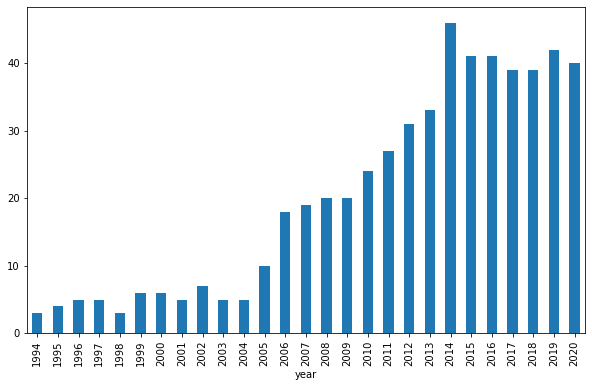

In [16]:
# plot the graph
plot_it(df=events_per_year,kind='bar');

So, according to this graph we can see that number of events has been steadily growing since 2005 reaching more than 40 events per year in mid 2010s (46 events in 2014). That is actually not a coincidense. In 2005 UFC launched its reality show, Ultimate Fighter, on Spike TV which became a huge success and exploded UFC popularity. Since 2014 UFC has been hosting around 40 events per year which is also true for 2020. Despite global pandemic the promotion will have 41 events this year. And considering all major sports were on a lockdown, I'm sure promotion's PPV numbers have also been on a high level (although this information is not disclosed so I cannot check it).

Next is to define the most common destinations (city) for UFC events. 'event place' column will help with that. The column has a name of the city, state (if in US) and country for every UFC event. We need a separate city names and count the number of events in every one of them and take out top 10 cities for UFC event. Also we want to know if pandemic somehow effected the destinations in 2020.

In [17]:
# column for event city
events['event city'] = [place.split(',')[0].strip() for place in events['event place']]

In [18]:
# top 10 cities for UFC events
events_per_city = events.groupby('event city')['event name'].count().sort_values(ascending=False)[:10]
events_per_city

event city
Las Vegas         144
Abu Dhabi          12
London             11
Rio de Janeiro     10
Atlantic City       9
Anaheim             8
Sao Paulo           8
Newark              8
Chicago             7
Los Angeles         7
Name: event name, dtype: int64

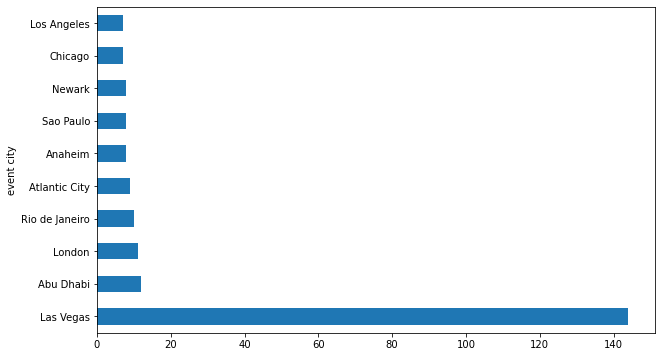

In [19]:
# plot the graph
plot_it(events_per_city,'barh');

In [20]:
# events per city in 2020
events_per_city_2020 = events[events['year']==2020].groupby('event city')['event name'].count().sort_values(ascending=False)
events_per_city_2020

event city
Las Vegas       22
Abu Dhabi        9
Jacksonville     3
Rio Rancho       1
Raleigh          1
Norfolk          1
Houston          1
Brasilia         1
Auckland         1
Name: event name, dtype: int64

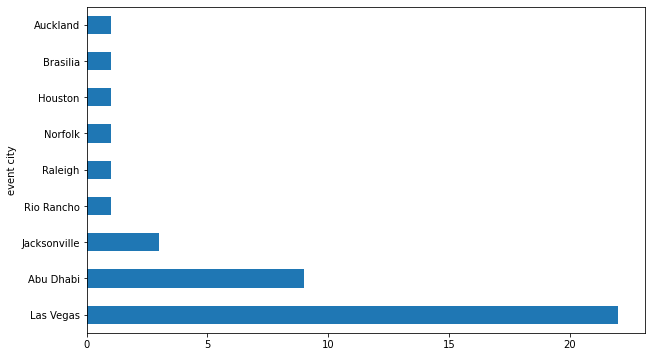

In [21]:
plot_it(events_per_city_2020,'barh');

So, Las Vegas is way far ahead in hosting UFC events. 144 (145 by the end of 202) events in UFC history happened in Sin City. Abu Dhabi, UAE, comes second with only 12 events. But unlike Las Vegas that has a huge lead, Abu Dhabi got into top 10 only this year because of 9 UFC events placed there in 2020. I guess, other than Las Vegas, global pandemic did effect what places UFC choose for their events.

Now, many people believe that the level of entartainment of the fight is measured on if there was an early stoppage or not. They find the fights that go the distance a little less exciting rather than if there is a KO or a submission victory. I don't think that's complety true but just to toy with that idea I want to know what weightclass in UFC has the most KO or submission victories.

In [22]:
# first, what type of victory is most common
fights['win method'].value_counts()

U-DEC         2041
KO/TKO        1956
SUB           1205
S-DEC          560
M-DEC           64
Overturned      45
DQ              17
CNC             15
Other            2
Name: win method, dtype: int64

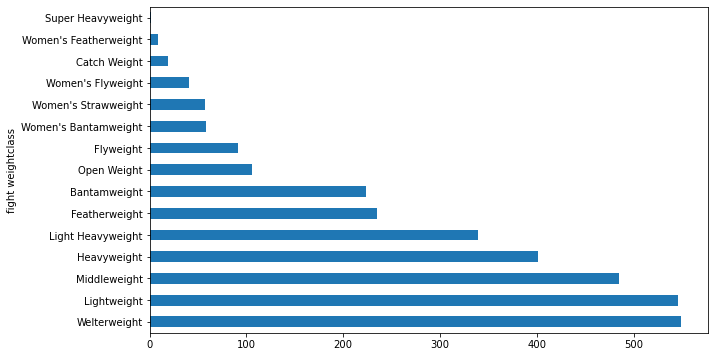

In [23]:
# a dataframe with number of early stoppage fights grouped by weightclass
early_stop = fights[(fights['win method']=='KO/TKO')|
                   (fights['win method']=='SUB')].groupby('fight weightclass')['Winner'].count().sort_values(ascending=False)
plot_it(early_stop,'barh');

If we look at this graph, it seems like most of welter- or lightweight fights don't go the distance. I think it's a bit misleading because I belive there are more fights in general in those weightclasses than, let's say, in women's featherweight.

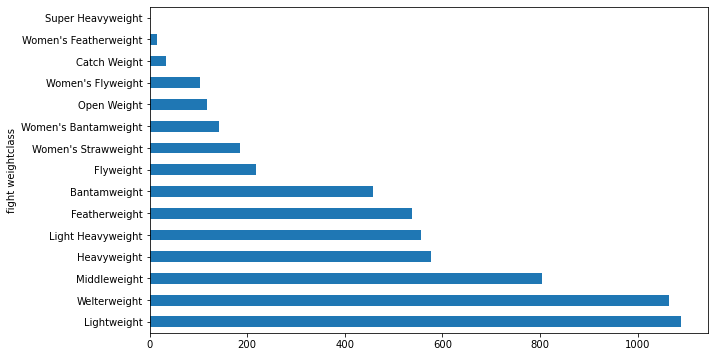

In [24]:
# total number of fights by weightclasses
total_fights = fights.groupby('fight weightclass')['Winner'].count().sort_values(ascending=False)
plot_it(total_fights,'barh');

But we want to know which weightclass is more exciting. We need to find a weightclass with highest percentage of fights stopped early.

In [25]:
# new dataframe with number of fights and stoppages by weightclasses
fights_by_weightclass = pd.concat([total_fights,early_stop], axis=1)
fights_by_weightclass.columns = ['Total fights','Stopped early']
fights_by_weightclass

,Total fights,Stopped early
Lightweight,1089,546
Welterweight,1065,549
Middleweight,805,485
Heavyweight,576,401
Light Heavyweight,556,339
Featherweight,538,235
Bantamweight,458,224
Flyweight,219,91
Women's Strawweight,186,57
Women's Bantamweight,143,58


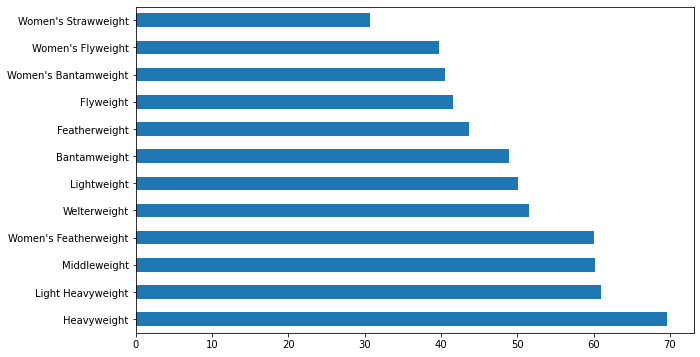

In [26]:
# and a new column to show % of fights stopped early
fights_by_weightclass['% stopped early'] = round(fights_by_weightclass['Stopped early']/fights_by_weightclass['Total fights']*100,
                                                 2)

# most exciting weightclass (drop first 2, super heavyweight and open weight, and catch weight 
# because they don't have them anymore)
exciting_weightclass = fights_by_weightclass['% stopped early'].sort_values(ascending=False)[2:].drop('Catch Weight', axis=0)
plot_it(exciting_weightclass,'barh');

So, heavyweight happens to be the most exciting weightclass in UFC with almost 70% of the fights didn't go the distance. Interestingly, in both men and women weightclasses, the bigger the fighters are the more likely the fight to be stoppage victory.

### The end